# A Model to target the users who did make a booking

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")
sns.set_context("talk")

# The train_users table

In [2]:
# import the train_users table

train_users = pd.read_csv('csvdata/train_users_2.csv')
train_users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [3]:
# clean up the timestamps in the train_users dataframe 

train_users.timestamp_first_active = pd.to_datetime(train_users.timestamp_first_active.astype(str))
train_users.date_first_booking = pd.to_datetime(train_users.date_first_booking)
train_users.date_account_created = pd.to_datetime(train_users.date_account_created)

train_users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaT,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,NaT,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [4]:
# only keep the users for whom date_account_created matches timestamp_first_active 
# this is true for all the users in the Airbnb test_users table, and for almost all the users in the train_users table 

train_users = train_users[train_users.timestamp_first_active.dt.date == train_users.date_account_created.dt.date]

In [5]:
# calculate the age buckets and add them to the train_users table 

def calc_age_bucket(age):
    '''
    this function calculates the five year age bucket, given the age
    '''
    if age < 100.0:
        return (age // 5.0) + 1.0
    elif age >= 100.0:
        return 21.0
    elif np.isnan(age):
        return 0.0

# clean up the bad age values 
train_users['age_bucket'] = train_users.age.apply(calc_age_bucket).astype('category')
train_users.loc[train_users.age > 100.0, 'age'] = np.nan
train_users.age = train_users.age.fillna(36.0) # 36 is the mean age. 

<div class='alert alert-info'>

Now we have both 5-year age buckets and numerical age data. In the 5 year buckets, the users with a missing age value get bucket 0.0, while in the numerical age column, they get the average age which is 36. This way, we have taken the most plausible age value, without losing the fact that age data was missing for them. 

</div>

In [6]:
# create features: year, month, day and dayofweek from date_account_created. 

train_users.loc[:,'year'] = train_users.date_account_created.dt.year.astype('category')
train_users.loc[:,'quarter'] = train_users.date_account_created.dt.quarter.astype('category')
train_users.loc[:,'month'] = train_users.date_account_created.dt.month.astype('category')
#train_users.loc[:,'day'] = train_users.date_account_created.dt.day.astype('category')
train_users.loc[:,'dayofweek'] = train_users.date_account_created.dt.dayofweek.astype('category')
train_users.loc[:,'hour'] = train_users.date_account_created.dt.hour.astype('category')

# mark a the following columns as categorical data
mylist = ['gender', 'signup_method', 'language', 'affiliate_channel', 
          'affiliate_provider', 'first_affiliate_tracked', 'signup_flow', 
          'signup_app', 'first_device_type', 'first_browser','age_bucket']
for x in mylist:
    train_users.loc[:,x] = train_users[x].astype('category')

# only keep the users from 2014 - the test set only involves the users from 2014 
train_users = train_users[(train_users.year == 2014)]

<div class='alert alert-info'>
Now all the timestamp data has been converted into categorical features that are more convenient, such as `year`, `quarter`, `month`, `dayofweek` and `hour`.
</div>

In [7]:
# use 'id' as the index and drop the columns that are not needed anymore

ids = train_users.id
train_users = train_users.set_index('id')
train_users = train_users.drop(['date_account_created', 'timestamp_first_active', 'country_destination'], axis=1)

In [8]:
# separate the date_first_booking column as a column of 1/0 
# these are the labels that indicate the conversion of the user 

y_users = train_users.date_first_booking.notnull().astype(int)

# drop all the date_first_booking values - they're not present in the test_users table. 

train_users = train_users.drop('date_first_booking', axis=1)

yes = y_users.sum() / float(len(y_users))
no = 1. - yes
print 'the proportion of the users who did book:', yes
print 'the proportion of the users who did NOT book:', no

the proportion of the users who did book: 0.382276361067
the proportion of the users who did NOT book: 0.617723638933


<div class='alert alert-danger'>
<h3> Caution! </h3>
<p>`y_users` is `1` if the user booked, and is `0` if the user did not book. We use these values so that later on we can build a model that has <strong>good precision</strong>, in order to <strong>target the users who are very likely to book</strong>. All the probabilities are probabilities that a user does book. </p>
</div>

# The sessions table

In [9]:
# import the sessions table

sessions = pd.read_csv('csvdata/sessions.csv')
sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [10]:
# add a large numbe of user activity features coming from the sessions table 
# this includes stuff such as number of clicks and the counts of many other things 
# all of this is numerical data

for y in ['action', 'action_type', 'action_detail', 'device_type']:
    df = sessions.groupby(['user_id', y]).size().unstack()
    for x in df.columns:
        s = df[x]
        train_users[y + '_' + x] = train_users.join(s)[x].fillna(0)
        
s = sessions.groupby(['user_id']).agg(np.max).secs_elapsed / 86400.0
train_users['total_days_spent'] = train_users.join(s).secs_elapsed.fillna(0.0)

# now train_users has a large number of features derived from the sessions table 
train_users.values.shape

(76429, 556)

<div class='alert alert-info'>
Now various user activity features have been added, such as number of times a user clicked, number of times a user viewed search results and many more. 
</div>

In [11]:
# import machine learning tools 

import sklearn
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [12]:
# convert the categorical variables into dummy variables

X_users = pd.get_dummies(train_users)

# split the data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X_users, y_users, test_size=0.20)

# standardize the data
scl = StandardScaler()
X_train = scl.fit_transform(X_train)
X_test = scl.transform(X_test)

# the training set is too large, so resample it for the purposes of cross validation. 
samples = np.random.choice(len(X_train), 1000, replace=False)
X_train_resampled = X_train[samples, :]
y_train_resampled = y_train[samples]

<div class='alert alert-info'>

Now all the categorical variables have been converted into dummy variables, the train and the test sets have been prepared and standardized to have zero mean and unit variance. We are ready to apply various machine learning algorithms to predict user conversion. The grid search for cross validation will only be run on a smaller random sample of the data, rather than the entire training set, because the entire training set is rather large. 

</div>

In [13]:
def perform_grid_search(clf, parameters, X, y):
    ''' 
    inputs: 
    clf : a classifier
    parameters : a dictionary specifying the parameter grid to search over 
    X : feature matrix
    y : class vector
    '''
    kf = KFold(n_splits=5, shuffle=True)
    gs = GridSearchCV(clf, param_grid=parameters, cv=kf)
    gs.fit(X, y)

    print 'best parameter combination found by grid search:' 
    print gs.best_params_
    print 'training a model using these parameters on the entire training data...'
    return gs.best_params_

In [14]:
def return_classifier_stats(prob_train, prob_test):
    '''
    this function returns the performance for the trained classifier
    that predicted prob_train and prob_test probabilities
    '''
    
#     if type(clf) == sklearn.ensemble.forest.RandomForestClassifier:
#         print 'out of bag score:', clf.oob_score_
    
    # check the performance on the training set
    predictions_train = (prob_train[:,1] > 0.5)
    training_score = accuracy_score(y_train, predictions_train)
    training_logloss = log_loss(y_train, prob_train)
    training_roc_auc_score = roc_auc_score(y_train, prob_train[:, 1])
    training_precision = precision_score(y_train, predictions_train)
    training_recall = recall_score(y_train, predictions_train)
    training_f1_score = f1_score(y_train, predictions_train)
    training = [training_score, training_logloss, training_roc_auc_score, 
                training_precision, training_recall, training_f1_score]

    # check the performance on the test set
    predictions_test = (prob_test[:,1] > 0.5)
    testing_score = accuracy_score(y_test, predictions_test)
    testing_logloss = log_loss(y_test, prob_test)
    testing_roc_auc_score = roc_auc_score(y_test, prob_test[:, 1])
    testing_precision = precision_score(y_test, predictions_test)
    testing_recall = recall_score(y_test, predictions_test)
    testing_f1_score = f1_score(y_test, predictions_test)
    testing = [testing_score, testing_logloss, testing_roc_auc_score, 
               testing_precision, testing_recall, testing_f1_score]
    
    # create a dataframe containing the stats
    df = pd.DataFrame([training, testing], index=['training', 'testing'], 
                      columns=['accuracy', 'log loss', 'roc auc score', 'precision', 'recall', 'f1 score'])
    return df

In [15]:
def plot_diagnostics(prob_train, prob_test):
    '''
    this function plots various diagnostics for the trained classifier 
    that predicted prob_train and prob_test probabilities
    
    '''
    fig, ((ax00, ax01), (ax10, ax11)) = plt.subplots(2, 2, figsize=(12,12))

    # plot the ROC curve 
    fpr, tpr, thresholds = roc_curve(y_test, prob_test[:, 1])
    ax00.plot(fpr, tpr, label='testing', color='blue')
    fpr, tpr, thresholds = roc_curve(y_train, prob_train[:, 1])
    ax00.plot(fpr, tpr, label='training', color='black')
    ax00.legend()
    ax00.set_xlabel('false positive rate')
    ax00.set_ylabel('true positive rate')
    ax00.set_title('ROC curve')

    # plot the precision-recall curve 
    precision, recall, thresholds = precision_recall_curve(y_test, prob_test[:, 1])
    ax01.plot(recall, precision, label='testing', color='blue')
    precision, recall, thresholds = precision_recall_curve(y_train, prob_train[:, 1])
    ax01.plot(recall, precision, label='training', color='black')
    ax01.legend()
    ax01.set_xlabel('recall')
    ax01.set_ylabel('precision')
    ax01.set_title('Precision-Recall curve')
    
    # plot the probability distribution for the two classes on the training set
    train_p1 = pd.Series(prob_train[:, 1], index=y_train).loc[1].values
    train_p0 = pd.Series(prob_train[:, 1], index=y_train).loc[0].values
    sns.distplot(train_p1, color='green', label='did book', ax=ax10)
    sns.distplot(train_p0, color='red', label='did NOT book', ax=ax10)
    ax10.legend()
    ax10.set_title('predicted probability distributions \nfor the two classes (training)')
    ax10.set_xlabel('predicted probability of booking')

    # plot the probability distribution for the two classes on the testing set
    test_p1 = pd.Series(prob_test[:, 1], index=y_test).loc[1].values
    test_p0 = pd.Series(prob_test[:, 1], index=y_test).loc[0].values
    sns.distplot(test_p1, color='green', label='did book', ax=ax11)
    sns.distplot(test_p0, color='red', label='did NOT book', ax=ax11)
    ax11.legend()
    ax11.set_title('predicted probability distributions \nfor the two classes (testing)')
    ax11.set_xlabel('predicted probability of booking')

    fig.tight_layout()

In [16]:
def vary_thresh(prob_train):
    '''vary the thresholds on the training set'''
    thresh = np.linspace(0.41, 0.59, 19)
    
    prt = precision_recall_curve(y_train, prob_train[:, 1])
    thresholds = prt[2]
    threshlist = np.linspace(0.41, 0.59, 19)
    closest = []
    for thresh in threshlist:
        closest.append(sorted(thresholds, key=lambda x: abs(x-thresh))[0])
    prt = zip(prt[0], prt[1], prt[2])
    df = pd.DataFrame(prt, columns=['precision' ,'recall', 'thresholds']).set_index('thresholds')
    df = df.loc[closest]
    df['threshold'] = threshlist
    df['F1_score'] = 2. * df.precision * df.recall / (df.precision + df.recall)
    accuracies = [((prob_train[:, 1] > mythreshold) == y_train).sum()/float(len(y_train)) for mythreshold in threshlist]
    df['accuracy'] = pd.Series(accuracies, index=df.index)
    return df.set_index('threshold').T

# Logistic Regression

In [17]:
parameters = {'penalty' : ['l1', 'l2'], 'C' : [0.01, 0.1, 1.0, 10.0, 100.0]}
clf = LogisticRegression()
best = perform_grid_search(clf, parameters, X_train_resampled, y_train_resampled)
logireg = LogisticRegression(**best)
logireg.fit(X_train, y_train)
prob_train = logireg.predict_proba(X_train)
prob_test = logireg.predict_proba(X_test)
return_classifier_stats(prob_train, prob_test)

best parameter combination found by grid search:
{'penalty': 'l1', 'C': 0.1}
training a model using these parameters on the entire training data...


,accuracy,log loss,roc auc score,precision,recall,f1 score
training,0.779844,0.475465,0.843031,0.736724,0.659979,0.696243
testing,0.776528,0.481488,0.839574,0.732911,0.653372,0.690860


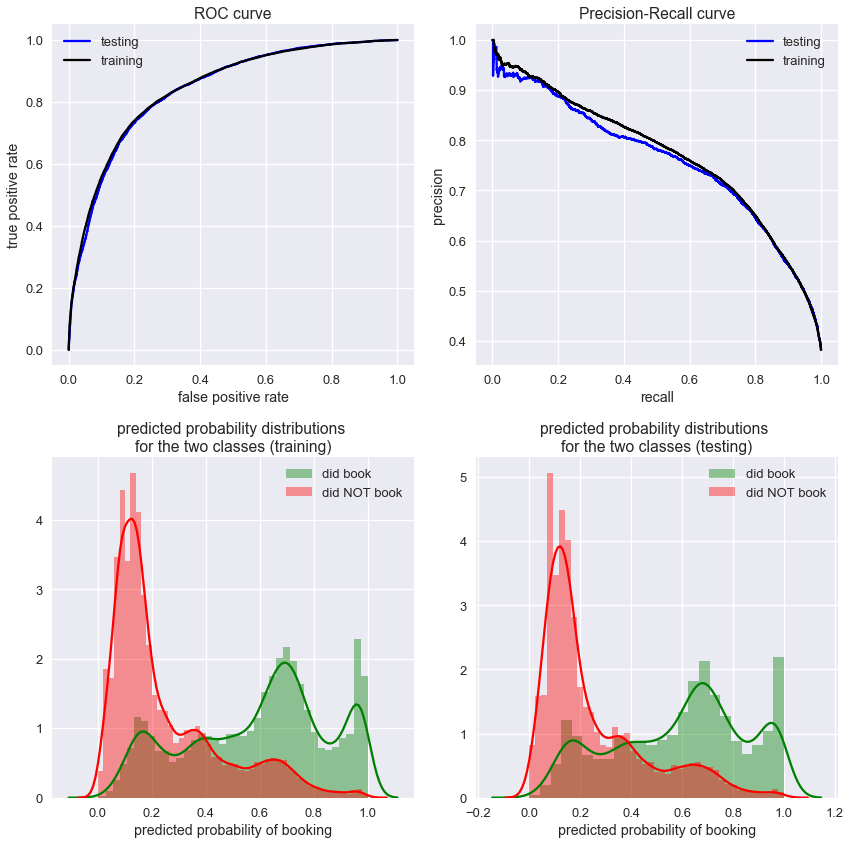

In [18]:
plot_diagnostics(prob_train, prob_test)

In [19]:
vary_thresh(prob_train)

threshold,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.5,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59
precision,0.699186,0.704456,0.708910,0.712974,0.717902,0.722193,0.725814,0.729457,0.733018,0.736724,0.739998,0.744290,0.747979,0.750797,0.753563,0.756985,0.761191,0.763968,0.769204
recall,0.735230,0.727059,0.718888,0.710717,0.702545,0.694973,0.687187,0.679401,0.669390,0.659979,0.650439,0.641283,0.633198,0.624342,0.615230,0.606203,0.597262,0.586139,0.575743
F1_score,0.716755,0.715579,0.713864,0.711843,0.710141,0.708322,0.705973,0.703540,0.699761,0.696243,0.692334,0.688958,0.685819,0.681756,0.677406,0.673255,0.669336,0.663342,0.658560
accuracy,0.777865,0.779043,0.779680,0.780008,0.780760,0.781185,0.781185,0.781120,0.780416,0.779844,0.778977,0.778650,0.778225,0.777162,0.775984,0.775052,0.774381,0.772566,0.771748


<div class='alert alert-info'>
Thresholding does not impact accuracy in any significant way. So to identify eager users with <strong>high precision</strong>, I recommend choosing a <strong>high threshold</strong>. Perhaps even a threshold higher than 0.6. 
</div>

# Random Forests

In [20]:
parameters = {'n_estimators' : [50, 100, 200, 400], 'min_impurity_split' : [0.00001, 0.0001, 0.001, 0.01, 0.1]}
clf = RandomForestClassifier(oob_score=True)
best = perform_grid_search(clf, parameters, X_train_resampled, y_train_resampled)
forest = RandomForestClassifier(oob_score=True, **best)
forest.fit(X_train, y_train)
prob_train = forest.predict_proba(X_train)
prob_test = forest.predict_proba(X_test)
return_classifier_stats(prob_train, prob_test)

best parameter combination found by grid search:
{'n_estimators': 400, 'min_impurity_split': 1e-05}
training a model using these parameters on the entire training data...


,accuracy,log loss,roc auc score,precision,recall,f1 score
training,0.999264,0.131563,0.999553,0.999700,0.998374,0.999037
testing,0.779733,0.480027,0.843400,0.727106,0.678192,0.701798


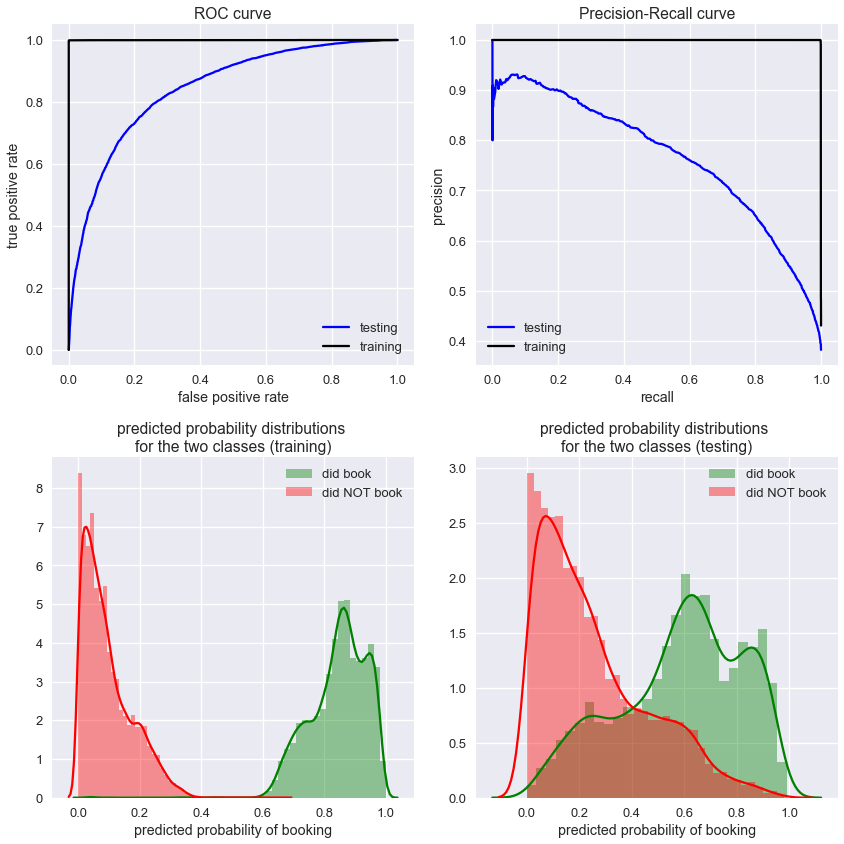

In [21]:
plot_diagnostics(prob_train, prob_test)

In [22]:
vary_thresh(prob_train)

threshold,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.5,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59
precision,0.999101,0.999144,0.999272,0.999315,0.999401,0.999529,0.999572,0.999615,0.999657,0.999657,0.999700,0.999743,0.999786,0.999786,0.999829,0.999829,0.999871,0.999871,0.999914
recall,0.998930,0.998888,0.998802,0.998759,0.998674,0.998545,0.998503,0.998460,0.998417,0.998417,0.998374,0.998332,0.998289,0.998289,0.998246,0.998246,0.998160,0.998118,0.997947
F1_score,0.999016,0.999016,0.999037,0.999037,0.999037,0.999037,0.999037,0.999037,0.999037,0.999037,0.999037,0.999037,0.999037,0.999037,0.999037,0.999037,0.999015,0.998994,0.998929
accuracy,0.999248,0.999248,0.999264,0.999264,0.999264,0.999264,0.999264,0.999264,0.999264,0.999264,0.999264,0.999264,0.999264,0.999264,0.999264,0.999264,0.999231,0.999231,0.999182


<div class='alert alert-info'>
Logistic regression and random Forest have similar performance on the test set, but random forest is grossly overfitting. Thresholding doesn't really make any sense in this case. Therefore I recommend choosing logistic regression over random forest in this case. 
</div>

# Average of logistic regression and random forest

In [23]:
# average of logistic regression and random forest

prob_train = (logireg.predict_proba(X_train) + forest.predict_proba(X_train)) / 2.0 
prob_test = (logireg.predict_proba(X_test) + forest.predict_proba(X_test)) / 2.0 

return_classifier_stats(prob_train, prob_test)

,accuracy,log loss,roc auc score,precision,recall,f1 score
training,0.922559,0.266767,0.985604,0.942419,0.849326,0.893454
testing,0.780714,0.467953,0.848017,0.733496,0.669463,0.700018


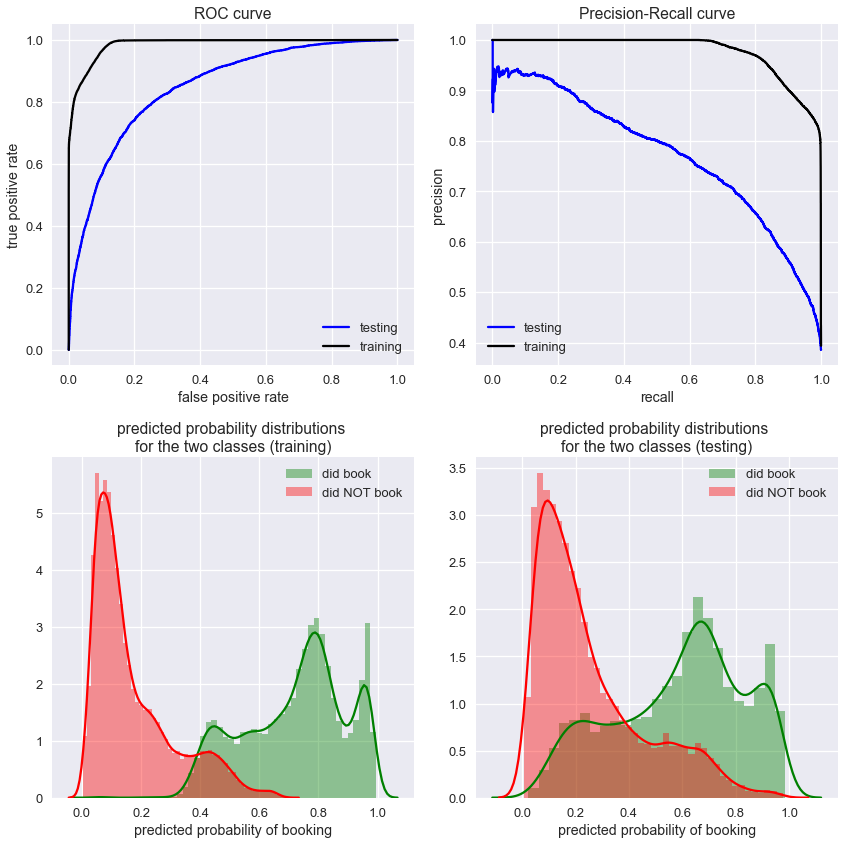

In [24]:
plot_diagnostics(prob_train, prob_test)

In [25]:
vary_thresh(prob_train)

threshold,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.5,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59
precision,0.859703,0.867653,0.876960,0.886977,0.896556,0.905455,0.915686,0.924744,0.934185,0.942374,0.948858,0.956629,0.961716,0.966160,0.970055,0.973085,0.976015,0.978310,0.980267
recall,0.960513,0.948535,0.935487,0.921583,0.907679,0.894802,0.882310,0.870545,0.859850,0.849326,0.838973,0.829433,0.819979,0.809797,0.798246,0.785711,0.774674,0.762182,0.750203
F1_score,0.907316,0.906293,0.905278,0.903949,0.902083,0.900097,0.898688,0.896827,0.895478,0.893434,0.890539,0.888502,0.885210,0.881095,0.875804,0.869417,0.863766,0.856827,0.849942
accuracy,0.924979,0.924996,0.925159,0.925126,0.924652,0.924063,0.923965,0.923425,0.923262,0.922559,0.921136,0.920400,0.918682,0.916442,0.913432,0.909769,0.906563,0.902605,0.898729


<div class='alert alert-info'>
Averaging yields no significant improvement over logistic regression. 
</div>

# Logical AND of Logistic regression and Random forest

In [26]:
# we try the logical and of logistic regression and random forest
# since we want results biased toward one rather than toward zero
# (remember, our data is skewed: ~60% users did not book)

prob_train = np.logical_and(logireg.predict(X_train), forest.predict(X_train))
print 'training accuracy:', (prob_train == y_train).sum() / float(len(y_train))

prob_test = np.logical_and(logireg.predict(X_test), forest.predict(X_test))
print 'testing accuracy:', (prob_test == y_test).sum() / float(len(y_test))

training accuracy: 0.869944229102
testing accuracy: 0.776265864189


# Logical OR of Logistic regression and Random forest

In [27]:
# we try the logical or of logistic regression and random forest
# in the hope of improving the accuracy

prob_train = np.logical_or(logireg.predict(X_train), forest.predict(X_train))
print 'training accuracy:', (prob_train == y_train).sum() / float(len(y_train))

prob_test = np.logical_or(logireg.predict(X_test), forest.predict(X_test))
print 'testing accuracy:', (prob_test == y_test).sum() / float(len(y_test))

training accuracy: 0.909163763636
testing accuracy: 0.779994766453


<div class='alert alert-info'>
We tried to handle conflicting predictions made by logistic regression and by random forest in two ways: by taking logical AND and by taking logical OR. No significant improvement on the test scores, but logical AND is less overfitting compared to logical OR and random forest. Logistic regression is still the best model so far. 
</div>

# Feature engineering and retraining

number of top features,10,20,30,40,50,60,70,80,90,100
cumulative importance,0.223794,0.346279,0.44132,0.516717,0.576767,0.627632,0.670988,0.709918,0.745651,0.77841


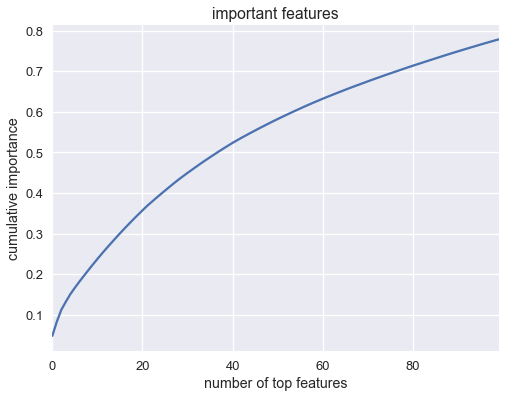

In [28]:
# print feature importances 

s = pd.Series(forest.feature_importances_).sort_values(ascending=False)

importances = pd.Series(s[:100].values)
importances.cumsum().plot(figsize=(8,6))
plt.xlabel('number of top features')
plt.ylabel('cumulative importance')
plt.title('important features')

n_features = np.linspace(10,100,10).astype(int)
total_importances = [s[:n].sum() for n in n_features]
pd.DataFrame(zip(n_features, total_importances), columns=['number of top features', 'cumulative importance']).set_index('number of top features').T

In [29]:
# We retain top 40 features with the highest importance

X_train_reduced = X_train[:, s.iloc[:40].index]
X_test_reduced = X_test[:, s.iloc[:40].index]

#samples = np.random.choice(len(X_train_reduced), 1000, replace=False)
X_train_resampled_reduced = X_train_reduced[samples, :]
y_train_resampled_reduced = y_train[samples]

## Logistic Regression on the Important Features

In [30]:
# Logistic Regression on the important features 

parameters = {'penalty' : ['l1', 'l2'], 'C' : [0.01, 0.1, 1.0, 10.0, 100.0]}
clf = LogisticRegression()
best = perform_grid_search(clf, parameters, X_train_resampled_reduced, y_train_resampled_reduced)
logireg2 = LogisticRegression(**best)
logireg2.fit(X_train_reduced, y_train)
prob_train = logireg2.predict_proba(X_train_reduced)
prob_test = logireg2.predict_proba(X_test_reduced)
return_classifier_stats(prob_train, prob_test)

best parameter combination found by grid search:
{'penalty': 'l1', 'C': 0.1}
training a model using these parameters on the entire training data...


,accuracy,log loss,roc auc score,precision,recall,f1 score
training,0.770963,0.500414,0.824868,0.707829,0.682695,0.695035
testing,0.772014,0.498037,0.826995,0.711999,0.677508,0.694325


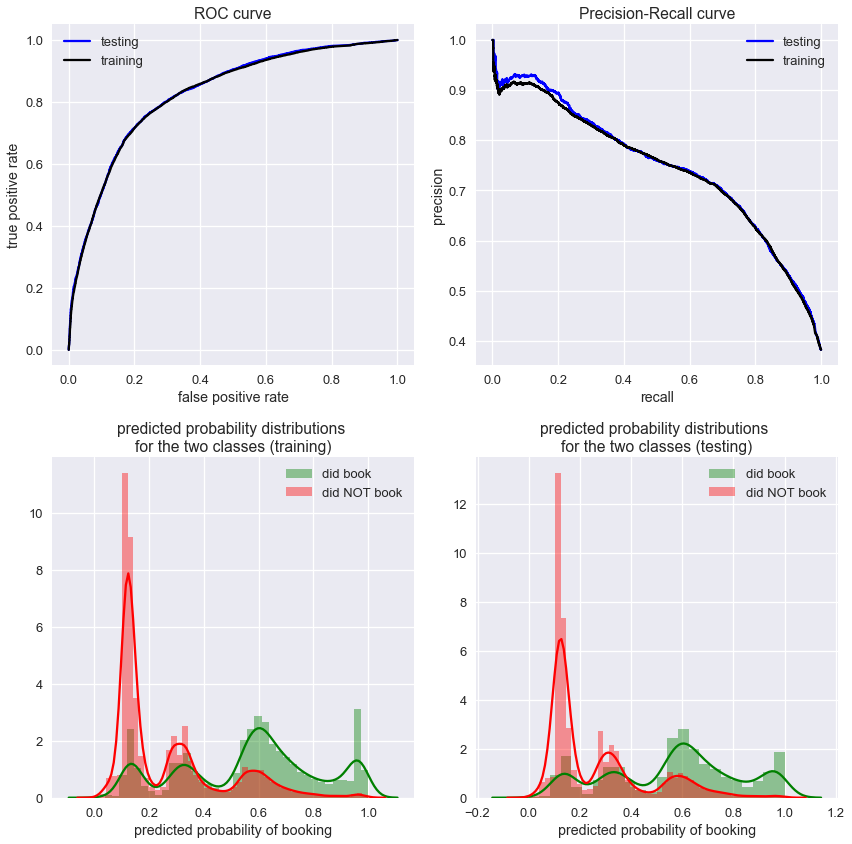

In [31]:
plot_diagnostics(prob_train, prob_test)

In [32]:
vary_thresh(prob_train)

threshold,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.5,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59
precision,0.691035,0.693080,0.695383,0.697236,0.699570,0.701438,0.703290,0.704717,0.706279,0.707829,0.709776,0.712866,0.714563,0.719900,0.727844,0.734730,0.740794,0.747323,0.753095
recall,0.711316,0.705711,0.702374,0.698310,0.695230,0.693005,0.690353,0.687743,0.685219,0.682695,0.679016,0.672214,0.661219,0.649711,0.624684,0.603123,0.578310,0.555337,0.530952
F1_score,0.701029,0.699339,0.698861,0.697773,0.697393,0.697196,0.696762,0.696127,0.695590,0.695035,0.694055,0.691944,0.686857,0.683007,0.672330,0.662453,0.649545,0.637182,0.622808
accuracy,0.768036,0.768019,0.768592,0.768739,0.769328,0.769867,0.770276,0.770456,0.770734,0.770963,0.771143,0.771176,0.769524,0.769458,0.767218,0.765026,0.761428,0.758223,0.754117


<div class='alert alert-info'>
We retain the top 40 important features identified by random forest and train a logistic regression on the smaller set of features. The results are very similar to the original logistic regression model. 
</div>

# Feature Engineering - adding Squared Features

In [33]:
X_train_reduced = pd.DataFrame(X_train_reduced)
XX_train = pd.DataFrame(columns=[], index=X_train_reduced.index)

for i in X_train_reduced.columns:
    XX_train[str(i)] = X_train_reduced[i] # degree one features
    for j in X_train_reduced.columns[i:]:
        XX_train[str(i) + '*' + str(j)] = X_train_reduced[i] * X_train_reduced[j] # degree two features 

In [34]:
X_test_reduced = pd.DataFrame(X_test_reduced)
XX_test = pd.DataFrame(columns=[], index=X_test_reduced.index)

for i in X_test_reduced.columns:
    XX_test[str(i)] = X_test_reduced[i]
    for j in X_test_reduced.columns[i:]:
        XX_test[str(i) + '*' + str(j)] = X_test_reduced[i] * X_test_reduced[j]

In [35]:
# standardize the data
scl2 = StandardScaler()
XX_train = scl2.fit_transform(XX_train)
XX_test = scl2.transform(XX_test)

# resample the data for cross validation
# samples = np.random.choice(len(XX_train), 1000, replace=False)
XX_train_resampled = XX_train[samples, :]
yy_train_resampled = y_train[samples]

XX_train.shape

(61143, 860)

In [36]:
# Logistic Regression on the squared features 

parameters = {'penalty' : ['l1', 'l2'], 'C' : [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]}
clf = LogisticRegression()
best = perform_grid_search(clf, parameters, XX_train_resampled, yy_train_resampled)
logireg3 = LogisticRegression(**best)
logireg3.fit(XX_train, y_train)
prob_train = logireg3.predict_proba(XX_train)
prob_test = logireg3.predict_proba(XX_test)
return_classifier_stats(prob_train, prob_test)

best parameter combination found by grid search:
{'penalty': 'l1', 'C': 0.1}
training a model using these parameters on the entire training data...


,accuracy,log loss,roc auc score,precision,recall,f1 score
training,0.775804,0.482302,0.836259,0.712471,0.693390,0.702801
testing,0.772929,0.491400,0.832689,0.712265,0.680931,0.696246


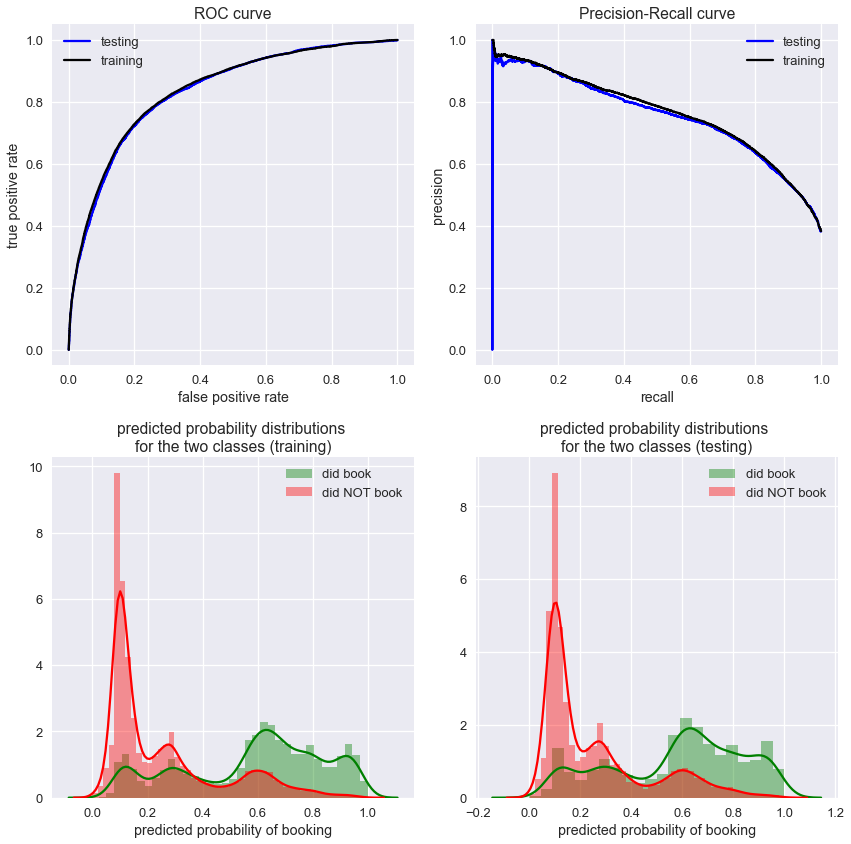

In [37]:
plot_diagnostics(prob_train, prob_test)

In [38]:
vary_thresh(prob_train)

threshold,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.5,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59
precision,0.689847,0.692924,0.695633,0.698070,0.699862,0.702675,0.704531,0.707155,0.710000,0.712440,0.715448,0.718854,0.722082,0.725672,0.729786,0.735959,0.740888,0.747958,0.754545
recall,0.733348,0.728941,0.723636,0.719572,0.714952,0.711273,0.707123,0.703102,0.698610,0.693390,0.688727,0.682781,0.675251,0.668021,0.658353,0.645219,0.628749,0.607230,0.589433
F1_score,0.710932,0.710476,0.709358,0.708658,0.707326,0.706948,0.705825,0.705123,0.704259,0.702786,0.701833,0.700353,0.697882,0.695654,0.692232,0.687608,0.680228,0.670287,0.661847
accuracy,0.771994,0.772860,0.773302,0.773809,0.773793,0.774545,0.774659,0.775166,0.775690,0.775804,0.776279,0.776638,0.776475,0.776540,0.776180,0.775886,0.774005,0.771634,0.769720


<div class='alert alert-info'>
We add all possible order two polynomial features in the hope of improving the bias of the logistic regression model. The resulting model is slightly better than the logistic regression with top 40 features, but no better than the original logistic regression model. 
</div>

<div class='alert alert-info'>
<h1> Concluding Remarks: </h1>
<p>We recommend using the original logistic regression model `logireg` with a <strong>high threshold</strong> in order to identify the <strong>eager users</strong> with <strong>high precision</strong>. These users may then be targeted with less discounts or promotions in order to improve the revenue. </p>
</div>